In [1]:
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture

print('CIFAR10-DVS downloadable', CIFAR10DVS.downloadable())
print('resource, url, md5/n', CIFAR10DVS.resource_url_md5())

print('DVS128Gesture downloadable', DVS128Gesture.downloadable())
print('resource, url, md5/n', DVS128Gesture.resource_url_md5())

d:\dev\anaconda3\envs\snn\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


CIFAR10-DVS downloadable True
resource, url, md5/n [('airplane.zip', 'https://ndownloader.figshare.com/files/7712788', '0afd5c4bf9ae06af762a77b180354fdd'), ('automobile.zip', 'https://ndownloader.figshare.com/files/7712791', '8438dfeba3bc970c94962d995b1b9bdd'), ('bird.zip', 'https://ndownloader.figshare.com/files/7712794', 'a9c207c91c55b9dc2002dc21c684d785'), ('cat.zip', 'https://ndownloader.figshare.com/files/7712812', '52c63c677c2b15fa5146a8daf4d56687'), ('deer.zip', 'https://ndownloader.figshare.com/files/7712815', 'b6bf21f6c04d21ba4e23fc3e36c8a4a3'), ('dog.zip', 'https://ndownloader.figshare.com/files/7712818', 'f379ebdf6703d16e0a690782e62639c3'), ('frog.zip', 'https://ndownloader.figshare.com/files/7712842', 'cad6ed91214b1c7388a5f6ee56d08803'), ('horse.zip', 'https://ndownloader.figshare.com/files/7712851', 'e7cbbf77bec584ffbf913f00e682782a'), ('ship.zip', 'https://ndownloader.figshare.com/files/7712836', '41c7bd7d6b251be82557c6cce9a7d5c9'), ('truck.zip', 'https://ndownloader.figs

In [2]:
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture

root_dir = '../datasets/DVS128Gesture'
train_set = DVS128Gesture(root_dir, train=True, data_type='frame', frames_number=20, split_by='number')

Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\0].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\1].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\10].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\2].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\3].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\4].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\5].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\6].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\7].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\8].
Mkdir [../datasets/DVS128Gesture\frames_number_20_split_by_number\test\9].
Mkdir [../datasets/DVS128Gesture\

In [2]:
#打印一帧
from spikingjelly.datasets import play_frame
import random

# 获取所有类别标签
labels = set()
for _, label in train_set:
    labels.add(label)
    if len(labels) == 11:  # DVS128Gesture 共11类
        break

import matplotlib.pyplot as plt

shown = set()
for idx in range(len(train_set)):
    frame, label = train_set[idx]
    if label not in shown:
        print(f'类别: {label}')
        # 假设 frame shape 为 [T, C, H, W]，你可以只显示第一帧的第一个通道
        plt.imshow(frame[0, 0])
        plt.title(f'类别: {label}')
        plt.show()
        shown.add(label)
    if len(shown) == 11:
        break

NameError: name 'train_set' is not defined

In [ ]:
#固定时间积分，10ms一次
import torch
from torch.utils.data import DataLoader
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask, dvs128_gesture
root='../datasets/DVS128Gesture'
train_set = dvs128_gesture.DVS128Gesture(root, data_type='frame', duration=1000000, train=True)
for i in range(5):
    x, y = train_set[i]
    print(f'x[{i}].shape=[T, C, H, W]={x.shape}')
train_data_loader = DataLoader(train_set, collate_fn=pad_sequence_collate, batch_size=5)
for x, y, x_len in train_data_loader:
    print(f'x.shape=[N, T, C, H, W]={tuple(x.shape)}')
    print(f'x_len={x_len}')
    mask = padded_sequence_mask(x_len)  # mask.shape = [T, N]
    print(f'mask=\n{mask.t().int()}')
    break

In [9]:
#简单的空间-时间滤波
%pip install scipy
from typing import Dict
import numpy as np
import spikingjelly.datasets as sjds
from scipy.spatial import cKDTree

def fast_filter_events(events: Dict, min_neighbors=1, time_window=1000):
    """
    用KDTree加速的空间-时间滤波
    """
    t, x, y, p = (events[key] for key in ('t', 'x', 'y', 'p'))
    # 构建空间-时间特征
    features = np.stack([t // time_window, x, y], axis=1)
    tree = cKDTree(features)
    # 查询每个点的邻居数（包括自身）
    counts = tree.query_ball_point(features, r=1, return_length=True)
    keep = np.where(counts > min_neighbors)[0]
    return {
        't': t[keep],
        'x': x[keep],
        'y': y[keep],
        'p': p[keep]
    }

def integrate_events_to_2_frames_denoised(events: Dict, H: int, W: int):
    # 用加速版滤波
    events = fast_filter_events(events, min_neighbors=1, time_window=1000)
    if len(events['t']) == 0:
        # 没有事件，直接返回全零帧
        return np.zeros([2, 2, H, W])
    index_split = np.random.randint(low=0, high=len(events['t']))
    frames = np.zeros([2, 2, H, W])
    t, x, y, p = (events[key] for key in ('t', 'x', 'y', 'p'))
    frames[0] = sjds.integrate_events_segment_to_frame(x, y, p, H, W, 0, index_split)
    frames[1] = sjds.integrate_events_segment_to_frame(x, y, p, H, W, index_split, len(t))
    return frames

Note: you may need to restart the kernel to use updated packages.


In [3]:
#空间-时间-极性一致性滤波
from typing import Dict
import numpy as np
import spikingjelly.datasets as sjds
from scipy.spatial import cKDTree

def polarity_consistent_filter_events(events: Dict, min_neighbors=1, time_window=1000):
    """
    空间-时间-极性一致性滤波
    """
    t, x, y, p = (events[key] for key in ('t', 'x', 'y', 'p'))
    features = np.stack([t // time_window, x, y], axis=1)
    tree = cKDTree(features)
    # 查询每个点的邻居索引
    neighbors = tree.query_ball_point(features, r=1)
    keep = []
    for i, idxs in enumerate(neighbors):
        # 统计极性一致的邻居数（包括自己）
        same_polarity = np.sum(p[idxs] == p[i])
        if same_polarity > min_neighbors:
            keep.append(i)
    keep = np.array(keep)
    return {
        't': t[keep],
        'x': x[keep],
        'y': y[keep],
        'p': p[keep]
    }

def integrate_events_to_2_frames_denoised2(events: Dict, H: int, W: int):
    # 用极性一致性滤波
    events = polarity_consistent_filter_events(events, min_neighbors=1, time_window=1000)
    if len(events['t']) == 0:
        return np.zeros([2, 2, H, W])
    index_split = np.random.randint(low=0, high=len(events['t']))
    frames = np.zeros([2, 2, H, W])
    t, x, y, p = (events[key] for key in ('t', 'x', 'y', 'p'))
    frames[0] = sjds.integrate_events_segment_to_frame(x, y, p, H, W, 0, index_split)
    frames[1] = sjds.integrate_events_segment_to_frame(x, y, p, H, W, index_split, len(t))
    return frames

def integrate_events_to_16_frames_by_time(events: Dict, H: int, W: int):
    if len(events['t']) == 0:
        return np.zeros([16, 2, H, W])

    events = polarity_consistent_filter_events(events, min_neighbors=1, time_window=1000)

    t = events['t']
    x = events['x']
    y = events['y']
    p = events['p']

    t_start = t[0]
    t_end = t[-1]
    total_duration = t_end - t_start
    base_delta = total_duration // 16
    remainder = total_duration % 16

    frames = np.zeros([16, 2, H, W], dtype=np.float32)

    for i in range(16):
        t_low = t_start + i * base_delta + min(i, remainder)
        t_high = t_low + base_delta + (1 if i < remainder else 0)
        mask = np.logical_and(t >= t_low, t < t_high)
        frame = sjds.integrate_events_segment_to_frame(x[mask], y[mask], p[mask], H, W)
        frames[i] = frame

    return frames

In [4]:
train_set = DVS128Gesture(root_dir, 
                          train=True, 
                          data_type='frame', 
                          split_by='number', 
                          custom_integrate_function=integrate_events_to_16_frames_by_time)

Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\0].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\1].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\10].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\2].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\3].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\4].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\5].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\6].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\7].
Mkdir [../datasets/DVS128Gesture\integrate_events_to_16_frames_by_time\test\8].
Mkdir [../datasets/DVS128Gesture\integrate_event

In [ ]:
#自定义积分方法
from typing import Dict
import spikingjelly.datasets as sjds
import numpy as np
def integrate_events_to_2_frames_randomly(events: Dict, H: int, W: int):
    index_split = np.random.randint(low=0, high=events['t'].__len__())
    frames = np.zeros([2, 2, H, W])
    t, x, y, p = (events[key] for key in ('t', 'x', 'y', 'p'))
    frames[0] = sjds.integrate_events_segment_to_frame(x, y, p, H, W, 0, index_split)
    frames[1] = sjds.integrate_events_segment_to_frame(x, y, p, H, W, index_split, events['t'].__len__())
    return frames
train_set = DVS128Gesture(root_dir, train=True, data_type='frame', custom_integrate_function=integrate_events_to_2_frames_randomly)

In [ ]:
from spikingjelly.datasets import play_frame
frame, label = train_set[500]
play_frame(frame)

In [20]:
root='../datasets/DVS128Gesture'
train_set = DVS128Gesture(root, train=True, data_type='frame', frames_number=16, split_by='number')

The directory [../datasets/DVS128Gesture\frames_number_16_split_by_number] already exists.


类别: 0


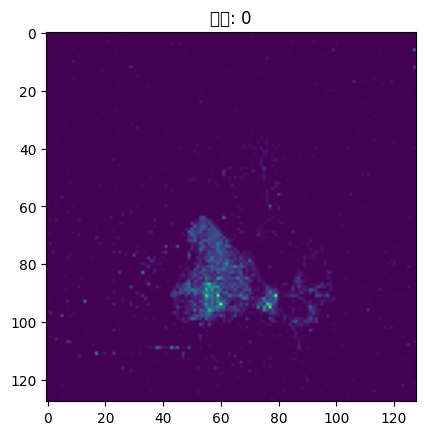

类别: 1


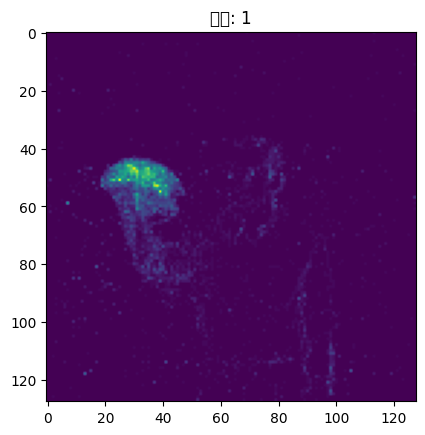

类别: 2


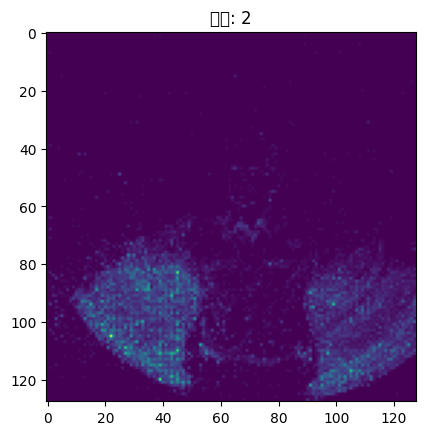

类别: 3


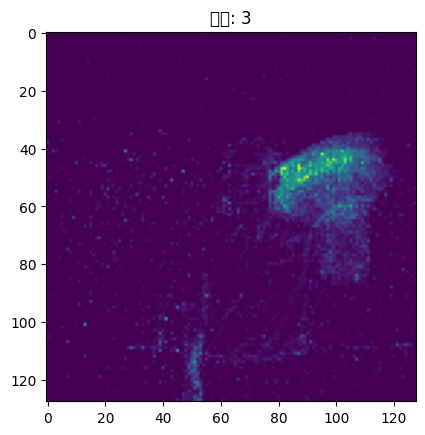

类别: 4


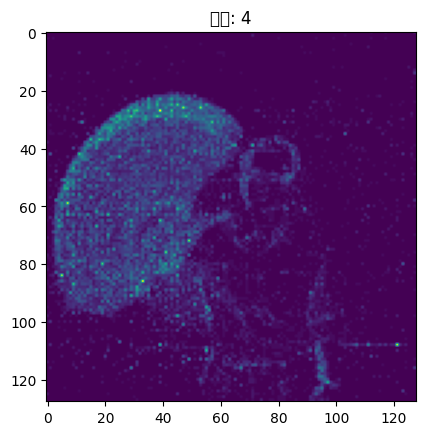

类别: 5


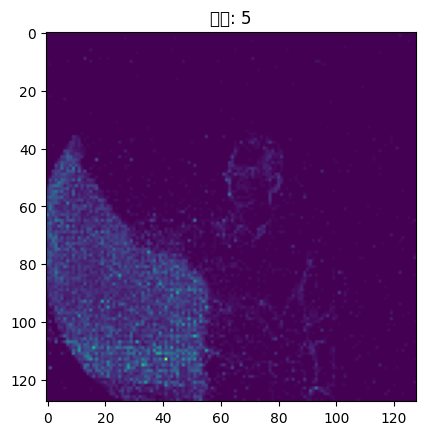

类别: 6


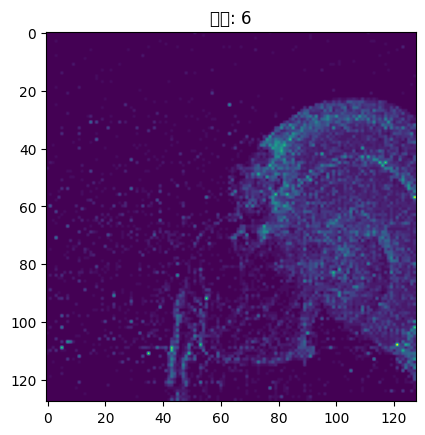

类别: 7


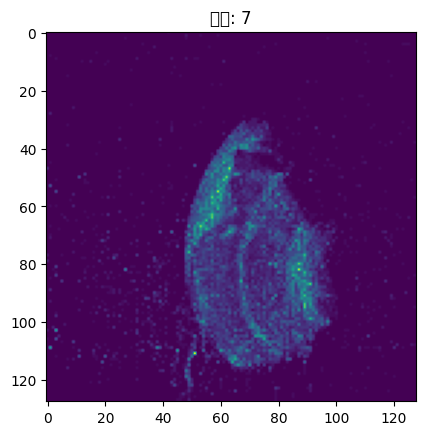

类别: 8


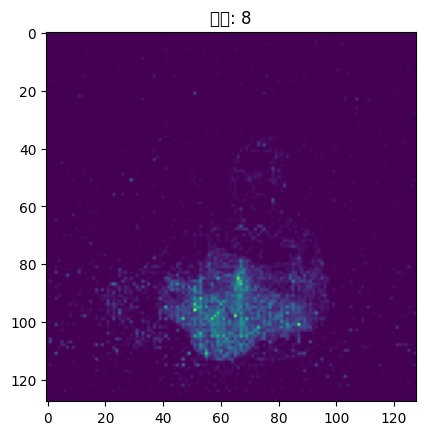

类别: 9


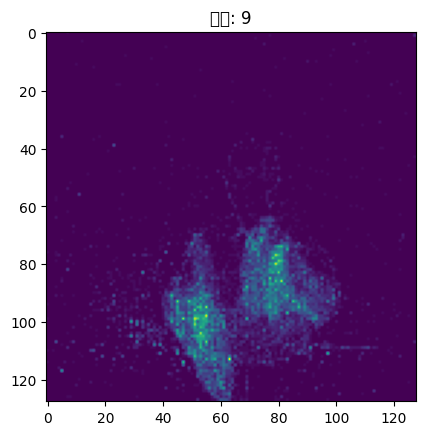

类别: 10


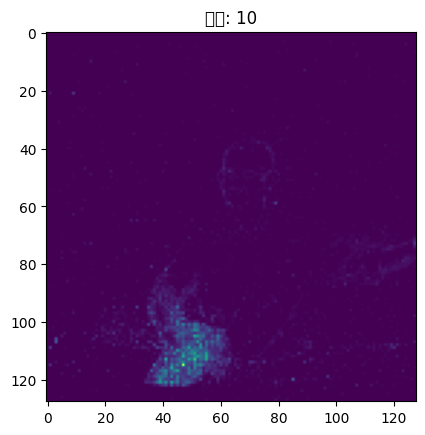

In [21]:
from spikingjelly.datasets import play_frame
import random

# 获取所有类别标签
labels = set()
for _, label in train_set:
    labels.add(label)
    if len(labels) == 11:  # DVS128Gesture 共11类
        break

import matplotlib.pyplot as plt

shown = set()
for idx in range(len(train_set)):
    frame, label = train_set[idx]
    if label not in shown:
        print(f'类别: {label}')
        # 假设 frame shape 为 [T, C, H, W]，你可以只显示第一帧的第一个通道
        plt.imshow(frame[0, 0])
        plt.title(f'类别: {label}')
        plt.show()
        shown.add(label)
    if len(shown) == 11:
        break